In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
# Google Colab GPU setup
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA is not available.  Training on CPU ...
Using device: cpu


In [3]:
# load data
images = np.load("images.npy")
print(images.shape)

labels = pd.read_csv("labels.csv")
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


In [4]:
# LABELS - DATA EXPLORATION
# check for missing values
print(labels.info())
print(labels.isna().sum())
# check for unique values
print(labels["Label"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB
None
Label    0
dtype: int64
['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent']


Label
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels Data')

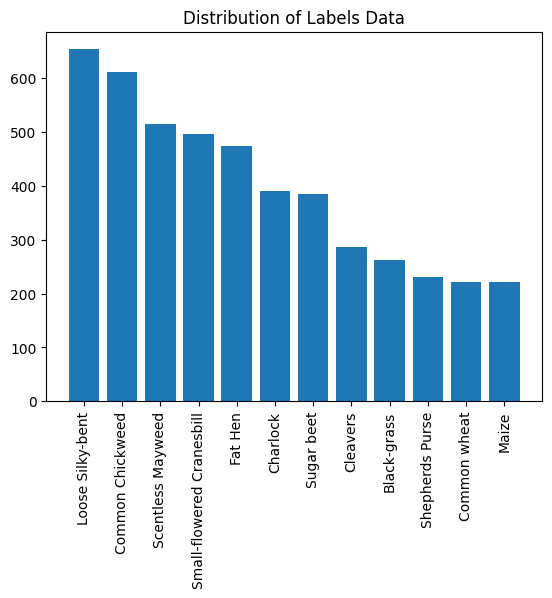

In [5]:
# explore distribution of labels data
counts = labels["Label"].value_counts()
print(counts)

plt.bar(counts.index, counts.values)
plt.xticks(rotation=90)
plt.title("Distribution of Labels Data")

In [6]:
# visualize 20 sample images with labels

# get 20 random images from data set
def get_samples_with_indices(data, num):
  indices = np.random.choice(len(data), size=num, replace=False)
  return data[indices], indices

samples = get_samples_with_indices(images, 20)
sample_imgs = samples[0]
sample_indices = samples[1]

# visualize sample images with labels
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
for i, sub in enumerate(axes.flat):
  sub.imshow(sample_imgs[i])
  sub.axis("off")
  sub.set_title(labels["Label"][sample_indices[i]])

In [7]:
# encode labels using LabelEncoder
encoder = LabelEncoder()
labels["Label"] = encoder.fit_transform(labels["Label"])

# create plant_map variable and print encoder mapping
print("Label mapping:")
plant_map = {}
for i, item in enumerate(encoder.classes_):
    plant_map[i] = item
    print(f"{item} : {i}")

print(plant_map)

Label mapping:
Black-grass : 0
Charlock : 1
Cleavers : 2
Common Chickweed : 3
Common wheat : 4
Fat Hen : 5
Loose Silky-bent : 6
Maize : 7
Scentless Mayweed : 8
Shepherds Purse : 9
Small-flowered Cranesbill : 10
Sugar beet : 11
{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


In [8]:
# Combine image vectors with labels before augmenting and splitting dataset
labeled_images = list(zip(images, labels["Label"])) # tuples

# double images from least-represented classes (with label counts under 400)
for item in labeled_images[0:4750]:
  # ["Charlock", "Sugar beet", "Cleavers", "Black-grass", "Shepherds Purse", "Common wheat", "Maize"] (less than 400 samples)
  if item[1] in [1, 11, 2, 0, 9, 4, 7]:
    labeled_images.append(item)

In [9]:
# visualize distribution of balanced dataset
label_list = [t[1] for t in labeled_images]
label_counts = pd.Series(label_list).value_counts()
print(label_counts)

plt.bar(label_counts.index, label_counts.values)
plt.xticks(range(0,12), plant_map.values(), rotation=90)
plt.title("Distribution of Labels Data After Augmentation")

1     780
11    770
6     654
3     611
2     574
0     526
8     516
10    496
5     475
9     462
4     442
7     442
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels Data After Augmentation')

In [10]:
# split data into training (80%), validation (10%), and testing (10%) datasets

train_len = int(len(labeled_images) * 0.8)
val_len = int((len(labeled_images) - train_len) / 2)
test_len = int(len(labeled_images) - train_len - val_len)

train_subset, val_subset, test_subset = torch.utils.data.random_split(
    labeled_images, [train_len, val_len, test_len]
)

print(f"Length of training subset: {len(train_subset)}")
print(f"Length of validation subset: {len(val_subset)}")
print(f"Length of testing subset: {len(test_subset)}")

Length of training subset: 5398
Length of validation subset: 675
Length of testing subset: 675


1     621
11    615
6     510
3     481
2     454
0     434
8     417
10    400
5     395
9     372
4     352
7     347
Name: count, dtype: int64


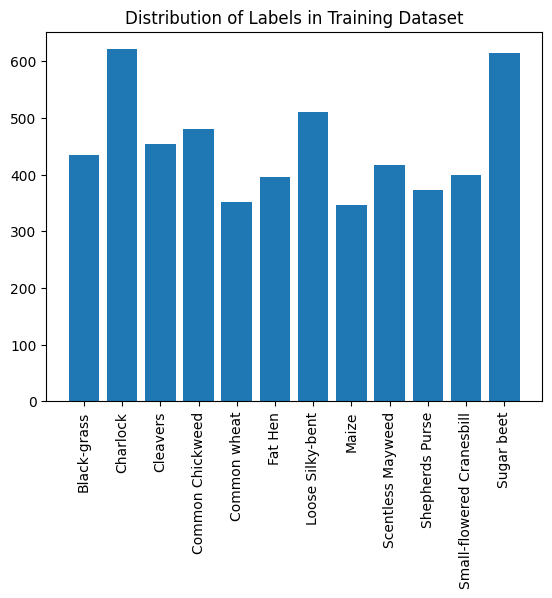

1     81
11    81
6     72
2     61
3     54
4     53
0     52
8     47
9     44
10    44
7     43
5     43
Name: count, dtype: int64


1     78
3     76
11    74
6     72
2     59
10    52
7     52
8     52
9     46
0     40
5     37
4     37
Name: count, dtype: int64


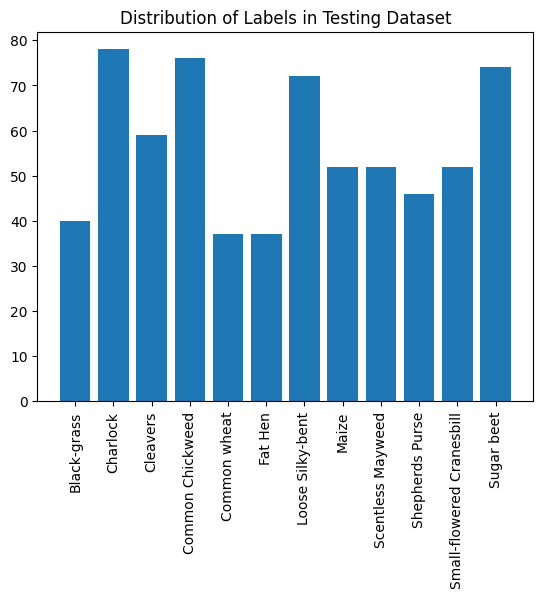

In [11]:
# visualize distribution of classes in training, validation, and test datasets
datasets = {"Training": train_subset, "Validation": val_subset, "Testing": test_subset}

for dataset in datasets.keys():
    label_list = [t[1] for t in datasets[dataset]]
    label_counts = pd.Series(label_list).value_counts()
    print(label_counts)

    plt.bar(label_counts.index, label_counts.values)
    plt.xticks(range(0,12), plant_map.values(), rotation=90)
    plt.title(f"Distribution of Labels in {dataset} Dataset")
    plt.show()

In [12]:
# unzip classes from images on training set
train_images, train_labels = zip(*train_subset)
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

# unzip classes from images on validation set
val_images, val_labels = zip(*val_subset)
val_images = np.asarray(val_images)
val_labels = np.asarray(val_labels)

# unzip classes from images on testing set
test_images, test_labels = zip(*test_subset)
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

# define transforms to normalize validation and test data
normalize_transforms = [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]

normalize_transform = transforms.Compose(normalize_transforms)

val_final_images = []
for i, img in enumerate(val_images):
  val_final_images.append(normalize_transform(img))

test_final_images = []
for i, img in enumerate(test_images):
  test_final_images.append(normalize_transform(img))

train_final_images = []
for i, img in enumerate(train_images):
  train_final_images.append(normalize_transform(img))

In [13]:
# define transforms to augment training data
training_transforms = [
    # random alteration of rotation, translation, shear
    transforms.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    ]

train_transform = transforms.Compose(training_transforms)

In [14]:
# save final datasets to csv

# training dataset with labels (normalized and augmented)
train_zip = list(zip(train_final_images, train_labels))
df1 = pd.DataFrame(train_zip)
df1.to_csv('training_final.csv', index=False)

# validation dataset with labels (normalized)
val_zip = list(zip(val_final_images, val_labels))
df2 = pd.DataFrame(val_zip)
df2.to_csv('validation_final.csv', index=False)

# testing dataset with labels (normalized)
test_zip = list(zip(test_final_images, test_labels))
df2 = pd.DataFrame(test_zip)
df2.to_csv('testing_final.csv', index=False)

In [15]:
# Create a custom data loader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_data, labels, transform=None):
        self.image_data = image_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        image = self.image_data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)

        return image, label

# Create the datasets and DataLoaders
train_dataset = CustomDataset(train_final_images, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CustomDataset(val_final_images, val_labels, transform=None)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = CustomDataset(test_final_images, test_labels, transform=None)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [16]:
# build CNN model

class Net(nn.Module):
    def __init__(self, n_classes=12):

        super(Net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x64x64

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32x32

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # -> 64x8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x16x16

            nn.AdaptiveAvgPool2d((1, 1)),   # reduces to (batch_size, 64, 1, 1)
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        return self.model(x)

model = Net()
model = model.to(device) # Move model to GPU
print(model)

# Source: Adapted from Udacity CNN course: https://udacity.com/enrollment/nd222-ent-wgu-data-sci-d604-2

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=64, out_features=12

In [17]:
# loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

patience = 7
best_val_loss = np.inf
counter = 0

In [18]:
# Training and Validation
n_epochs = 75

# create dataframe to store training and validation data
df_loss = pd.DataFrame(columns=["epoch", "train_loss", "valid_loss", "accuracy"])

# Loop over the epochs
for epoch in range(n_epochs):

    ### TRAINING LOOP ###
    model.train()

    # monitor training loss
    train_loss = 0.0

    # Loop over all the dataset using the training dataloader
    for data, target in tqdm(
        train_loader,
        desc="Training",
        total=len(train_loader),
        leave=True,
        ncols=80):

        # move data to GPU if available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # forward pass: compute predictions
        output = model(data)

        # calculate the loss which compare the model output with the target
        loss = criterion(output, target)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # update running training loss
        train_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    ### VALIDATION LOOP ###
    with torch.no_grad():
        model.eval()

        # Keep track of the validation loss
        valid_loss = 0.0
        correct = 0.0
        total = 0.0

        # Loop over validation data
        for batch_idx, (data, target) in tqdm(
            enumerate(val_loader),
            desc="Validation",
            total=len(val_loader),
            leave=True,
            ncols=80):

            # move data to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            output = model(data)

            loss_value = criterion(output, target)

            valid_loss = valid_loss + (
              (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            val_accuracy = 100.0 * correct / total

        # Save and print the losses
        df_loss.loc[epoch] = [epoch + 1, train_loss, valid_loss, val_accuracy]
        print(f"Epoch {epoch+1}: training loss {train_loss:.5f}, valid loss {valid_loss:.5f}, accuracy {val_accuracy:.5f}")

    scheduler.step(valid_loss)

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        counter = 0
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} / {patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break

    # Source: Code adapted from Udacity CNN course examples: https://udacity.com/enrollment/nd222-ent-wgu-data-sci-d604-2

Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.57it/s]


Epoch 1: training loss 2.13505, valid loss 1.80890, accuracy 43.55556


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.51it/s]


Epoch 2: training loss 1.73900, valid loss 1.51494, accuracy 48.14815


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch 3: training loss 1.52467, valid loss 1.39225, accuracy 56.44444


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.56it/s]


Epoch 4: training loss 1.39405, valid loss 1.32387, accuracy 52.29630


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.50it/s]


Epoch 5: training loss 1.30449, valid loss 1.27294, accuracy 59.55556


Validation: 100%|███████████████████████████████| 11/11 [00:08<00:00,  1.31it/s]


Epoch 6: training loss 1.22935, valid loss 1.07114, accuracy 65.33333


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.56it/s]


Epoch 7: training loss 1.17989, valid loss 1.11264, accuracy 60.29630
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch 8: training loss 1.12211, valid loss 0.95761, accuracy 68.00000


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.58it/s]


Epoch 9: training loss 1.08582, valid loss 0.95268, accuracy 68.88889


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.53it/s]


Epoch 10: training loss 1.04894, valid loss 0.89180, accuracy 69.77778


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.40it/s]


Epoch 11: training loss 1.01727, valid loss 1.00558, accuracy 63.25926
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.64it/s]


Epoch 12: training loss 0.99219, valid loss 0.89122, accuracy 68.59259


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 13: training loss 0.96152, valid loss 1.00029, accuracy 67.55556
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.47it/s]


Epoch 14: training loss 0.95368, valid loss 1.18377, accuracy 57.92593
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.47it/s]


Epoch 15: training loss 0.92591, valid loss 0.99807, accuracy 65.48148
EarlyStopping counter: 3 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.51it/s]


Epoch 16: training loss 0.90542, valid loss 0.74785, accuracy 74.66667


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.41it/s]


Epoch 17: training loss 0.87330, valid loss 0.90420, accuracy 69.03704
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.66it/s]


Epoch 18: training loss 0.86903, valid loss 1.03600, accuracy 61.48148
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.51it/s]


Epoch 19: training loss 0.84135, valid loss 0.69967, accuracy 76.74074


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.49it/s]


Epoch 20: training loss 0.84412, valid loss 1.21237, accuracy 57.77778
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.41it/s]


Epoch 21: training loss 0.84553, valid loss 0.75550, accuracy 73.18519
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.50it/s]


Epoch 22: training loss 0.81277, valid loss 2.07524, accuracy 46.22222
EarlyStopping counter: 3 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:08<00:00,  1.35it/s]


Epoch 23: training loss 0.78647, valid loss 0.84537, accuracy 68.44444
EarlyStopping counter: 4 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.39it/s]


Epoch 24: training loss 0.80416, valid loss 0.60105, accuracy 79.11111


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.68it/s]


Epoch 25: training loss 0.76567, valid loss 0.99091, accuracy 66.22222
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.57it/s]


Epoch 26: training loss 0.76443, valid loss 1.21014, accuracy 61.03704
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.40it/s]


Epoch 27: training loss 0.74183, valid loss 0.76067, accuracy 72.59259
EarlyStopping counter: 3 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.57it/s]


Epoch 28: training loss 0.73492, valid loss 0.62447, accuracy 77.92593
EarlyStopping counter: 4 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.49it/s]


Epoch 29: training loss 0.74415, valid loss 0.98536, accuracy 64.59259
EarlyStopping counter: 5 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:05<00:00,  1.89it/s]


Epoch 30: training loss 0.72034, valid loss 0.62581, accuracy 78.22222
EarlyStopping counter: 6 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.58it/s]


Epoch 31: training loss 0.69205, valid loss 0.57628, accuracy 80.44444


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.48it/s]


Epoch 32: training loss 0.67814, valid loss 0.60053, accuracy 78.37037
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.54it/s]


Epoch 33: training loss 0.68915, valid loss 0.68998, accuracy 75.25926
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.54it/s]


Epoch 34: training loss 0.67038, valid loss 0.59906, accuracy 79.25926
EarlyStopping counter: 3 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.55it/s]


Epoch 35: training loss 0.66778, valid loss 0.52571, accuracy 80.29630


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.49it/s]


Epoch 36: training loss 0.66649, valid loss 0.58490, accuracy 79.11111
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.62it/s]


Epoch 37: training loss 0.65396, valid loss 0.54855, accuracy 80.88889
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.75it/s]


Epoch 38: training loss 0.65230, valid loss 0.51040, accuracy 82.96296


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.52it/s]


Epoch 39: training loss 0.64042, valid loss 0.61012, accuracy 78.96296
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.50it/s]


Epoch 40: training loss 0.63789, valid loss 0.52823, accuracy 81.18519
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:08<00:00,  1.30it/s]


Epoch 41: training loss 0.63618, valid loss 0.76111, accuracy 70.81481
EarlyStopping counter: 3 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch 42: training loss 0.62994, valid loss 0.46059, accuracy 84.44444


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.72it/s]


Epoch 43: training loss 0.63041, valid loss 0.48710, accuracy 83.55556
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 44: training loss 0.62231, valid loss 0.63648, accuracy 76.74074
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.60it/s]


Epoch 45: training loss 0.62844, valid loss 0.48079, accuracy 82.96296
EarlyStopping counter: 3 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 46: training loss 0.60998, valid loss 0.54768, accuracy 79.85185
EarlyStopping counter: 4 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:05<00:00,  2.10it/s]


Epoch 47: training loss 0.60292, valid loss 0.58518, accuracy 78.81481
EarlyStopping counter: 5 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.64it/s]


Epoch 48: training loss 0.61583, valid loss 0.48796, accuracy 82.96296
EarlyStopping counter: 6 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch 49: training loss 0.57324, valid loss 0.45145, accuracy 85.03704


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.45it/s]


Epoch 50: training loss 0.58334, valid loss 0.44785, accuracy 83.85185


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.69it/s]


Epoch 51: training loss 0.59323, valid loss 0.50542, accuracy 83.25926
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.63it/s]


Epoch 52: training loss 0.58118, valid loss 0.58463, accuracy 77.48148
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 53: training loss 0.57068, valid loss 0.44306, accuracy 84.59259


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.41it/s]


Epoch 54: training loss 0.58961, valid loss 0.47680, accuracy 81.92593
EarlyStopping counter: 1 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 55: training loss 0.56771, valid loss 0.44656, accuracy 84.00000
EarlyStopping counter: 2 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.55it/s]


Epoch 56: training loss 0.57121, valid loss 0.57996, accuracy 79.55556
EarlyStopping counter: 3 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.39it/s]


Epoch 57: training loss 0.57124, valid loss 0.45453, accuracy 84.44444
EarlyStopping counter: 4 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


Epoch 58: training loss 0.57847, valid loss 0.44593, accuracy 85.33333
EarlyStopping counter: 5 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:07<00:00,  1.40it/s]


Epoch 59: training loss 0.56394, valid loss 0.44325, accuracy 84.88889
EarlyStopping counter: 6 / 7


Validation: 100%|███████████████████████████████| 11/11 [00:06<00:00,  1.74it/s]

Epoch 60: training loss 0.56195, valid loss 0.45620, accuracy 84.59259
EarlyStopping counter: 7 / 7
Early stopping triggered.


    epoch  train_loss  valid_loss   accuracy
0     1.0    2.135053    1.808905  43.555556
1     2.0    1.738997    1.514940  48.148148
2     3.0    1.524669    1.392245  56.444444
3     4.0    1.394045    1.323869  52.296296
4     5.0    1.304487    1.272941  59.555556
5     6.0    1.229349    1.071145  65.333333
6     7.0    1.179894    1.112642  60.296296
7     8.0    1.122113    0.957606  68.000000
8     9.0    1.085817    0.952678  68.888889
9    10.0    1.048935    0.891796  69.777778
10   11.0    1.017273    1.005585  63.259259
11   12.0    0.992194    0.891215  68.592593
12   13.0    0.961519    1.000294  67.555556
13   14.0    0.953678    1.183765  57.925926
14   15.0    0.925914    0.998072  65.481481
15   16.0    0.905415    0.747845  74.666667
16   17.0    0.873303    0.904204  69.037037
17   18.0    0.869026    1.035997  61.481481
18   19.0    0.841346    0.699672  76.740741
19   20.0    0.844118    1.212369  57.777778
20   21.0    0.845529    0.755501  73.185185
21   22.0 

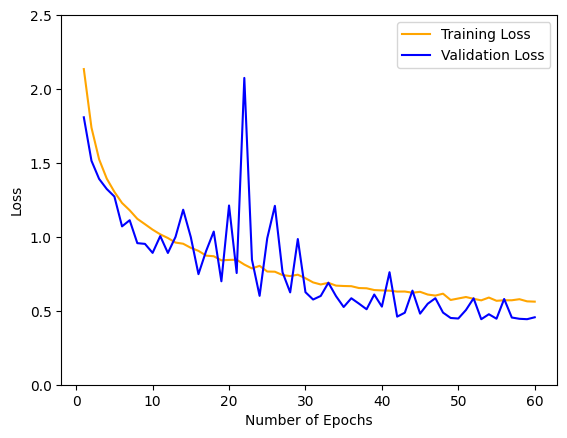

In [19]:
# visualize training and validation loss
print(df_loss)

plt.plot(df_loss["epoch"], df_loss["train_loss"], label="Training Loss", color="orange")
plt.plot(df_loss["epoch"], df_loss["valid_loss"], label="Validation Loss", color="blue")
plt.ylim(0.0, 2.5)
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.show()

In [20]:
# Print best model information
model.load_state_dict(torch.load('best_model.pth'))

print("Model Summary:")
print(summary(model, (3, 128, 128)))

print("Model Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           4,640
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
          Flatten-14    

In [21]:
# Evaluate best model with testing data

# monitor test loss and accuracy
test_loss = 0.
correct = 0.
total = 0.

with torch.no_grad():
    # set the model to evaluation mode
    model.eval()

    # if the GPU is available, move the model to the GPU
    if torch.cuda.is_available():
        model = model.cuda()

    # Loop over test dataset
    preds = []
    actuals = []

    for batch_idx, (data, target) in tqdm(
            enumerate(test_loader),
            desc='Testing',
            total=len(test_loader),
            leave=True,
            ncols=80
    ):
        # move data to GPU if available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # 1. forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)  # list of probabilities for each of the 12 classes

        # 2. calculate the loss
        loss_value = criterion(logits, target).detach()

        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss_value.data.item() - test_loss))

        # convert logits to predicted class (the index of the max of the logits)
        pred = logits.data.max(1, keepdim=True)[1]

        # compare predictions to true label
        correct += torch.sum(torch.squeeze(pred.eq(target.data.view_as(pred))).cpu())
        total += data.size(0)

        preds.extend(pred.data.cpu().numpy().squeeze())
        actuals.extend(target.data.view_as(pred).cpu().numpy().squeeze())

print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))

Testing: 100%|██████████████████████████████████| 11/11 [00:07<00:00,  1.56it/s]

Test Loss: 0.431558


Test Accuracy: 86% (582/675)


In [22]:
# plot confusion matrix

gt = pd.Series(actuals, name='Ground Truth')
predicted = pd.Series(preds, name='Predicted')

confusion_matrix = pd.crosstab(gt, predicted)
confusion_matrix.index = plant_map.values()

new_column_names = []
for col in confusion_matrix.columns.values:
    new_column_names.append(plant_map[col])
confusion_matrix.columns = new_column_names

display(confusion_matrix)

# visualize confusion matrix
fig, sub = plt.subplots()
with sns.plotting_context("notebook"):

    ax = sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt='d',
        ax=sub,
        linewidths=0.5,
        linecolor='lightgray',
        cbar=False
    )
    ax.set_xlabel("truth")
    ax.set_ylabel("pred")


Black-grass  Charlock  Cleavers  Common Chickweed  \
Black-grass                         25         0         1                 1   
Charlock                             0        72         3                 0   
Cleavers                             0         3        52                 0   
Common Chickweed                     0         0         0                65   
Common wheat                         0         0         0                 0   
Fat Hen                              1         1         0                 0   
Loose Silky-bent                    14         0         0                 0   
Maize                                0         2         0                 0   
Scentless Mayweed                    0         0         0                 4   
Shepherds Purse                      0         0         0                 2   
Small-flowered Cranesbill            0         0         0                 0   
Sugar beet                           0         3         1                 0   

                           Common wheat  Fat Hen  Loose Silky-bent  Maize  \
Black-grass                           1        1                11      0   
Charlock                              0        1                 0      0   
Cleavers                              1        1                 0      0   
Common Chickweed                      0        0                 1      0   
Common wheat                         35        2                 0      0   
Fat Hen                               2       33                 0      0   
Loose Silky-bent                      0        0                58      0   
Maize                                 0        0                 0     47   
Scentless Mayweed                     1        0                 0      0   
Shepherds Purse                       0        0                 0      0   
Small-flowered Cranesbill             1        0                 0      0   
Sugar beet                            0        2                 0      0   

                           Scentless Mayweed  Shepherds Purse  \
Black-grass                                0                0   
Charlock                                   0                0   
Cleavers                                   1                0   
Common Chickweed                           1                3   
Common wheat                               0                0   
Fat Hen                                    0                0   
Loose Silky-bent                           0                0   
Maize                                      0                1   
Scentless Mayweed                         44                3   
Shepherds Purse                            8               32   
Small-flowered Cranesbill                  0                0   
Sugar beet                                 0                0   

                           Small-flowered Cranesbill  Sugar beet  
Black-grass                                        0           0  
Charlock                                           2           0  
Cleavers                                           1           0  
Common Chickweed                                   6           0  
Common wheat                                       0           0  
Fat Hen                                            0           0  
Loose Silky-bent                                   0           0  
Maize                                              1           1  
Scentless Mayweed                                  0           0  
Shepherds Purse                                    4           0  
Small-flowered Cranesbill                         51           0  
Sugar beet                                         0          68

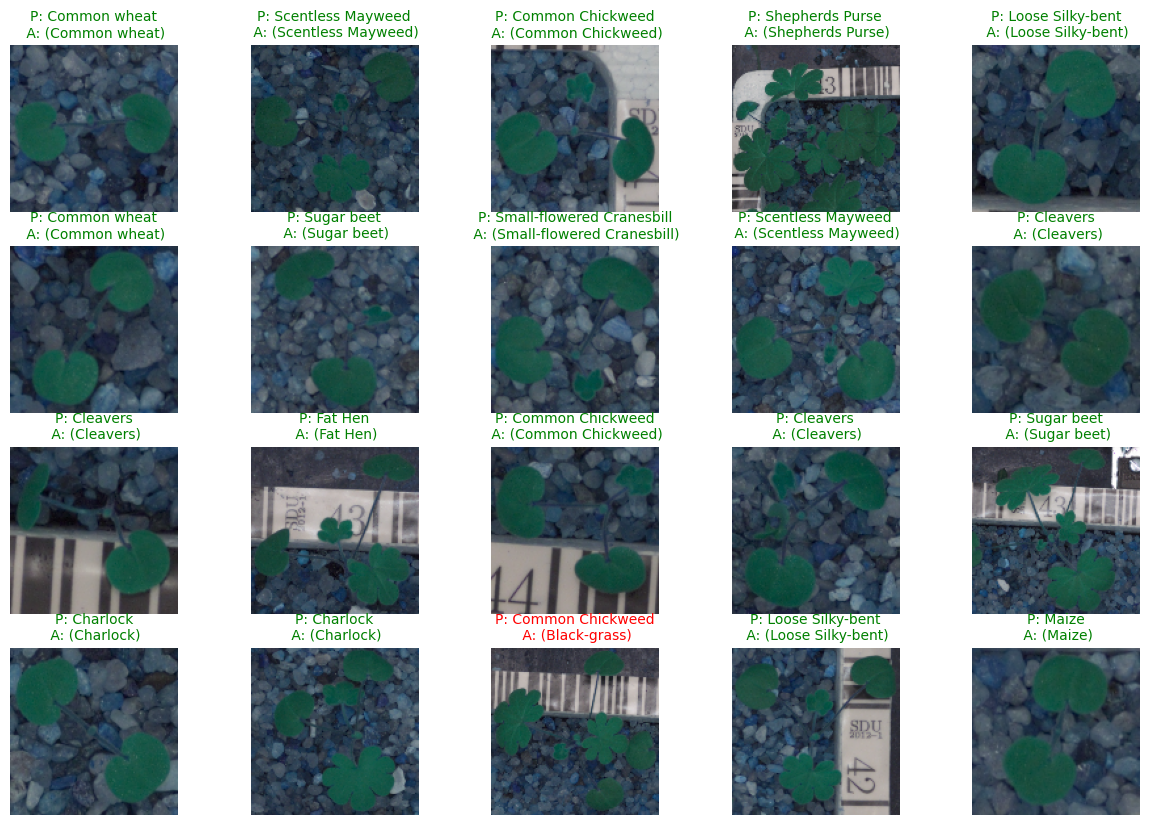

In [23]:
# visualize a batch of test images
dataiter = iter(test_loader)

for i in range(2):
    batch = next(dataiter)
    inputs, labels = batch
    labels = labels.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        imputs = inputs.cuda()

    # get sample outputs
    output = model(inputs)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # visualize sample images with predicted (true) labels
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))
    for i, sub in enumerate(axes.flat):
        sub.imshow(images[i])
        sub.axis("off")
        sub.set_title(f"P: {plant_map[preds[i]]}\n A: ({plant_map[labels[i]]})",
                      color=("green" if preds[i]==labels[i].item() else "red"),
                      fontsize=10)